In [2]:
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
import os
import numpy as np
from keras.applications.imagenet_utils import preprocess_input 
from keras.utils import np_utils
import random
import pprint
import cPickle
from scipy.misc import imread, imresize, imsave
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.engine.topology import Merge, merge
import matplotlib.pyplot as plt
from PIL import Image
# from keras.utils.visualize_util import plot
from scipy.ndimage.filters import gaussian_filter as gauss

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [ ]:
# train_datagen = ImageDataGenerator(
#         featurewise_center=True,
#         rescale=1./255,
#         dim_ordering='tf')

In [4]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
#     xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    return np.uint8(rgb.dot(xform.T))

In [5]:
random.seed(0)

X_train = []
Y_train = []

for directory in os.listdir('./data/'):
    l = os.listdir('./data/' + directory)
    for image in l:
        image = l[0]
        img = load_img('./data/' + directory + '/' + image, target_size=(224,224))  # this is a PIL image
        x = img_to_array(img)
        x = rgb2ycbcr(x)
        Y_train.append(x[:,:,1:])
        X_train.append(x[:,:,:1])
    break
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [6]:
XX_train = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] + 2))
XX_train[:,:,:,0:] = X_train
XX_train.shape

(114, 224, 224, 3)

In [64]:
def getModel():
    ''' 
        * return: compiled model (keras.engine.training.Model)
    '''
    vgg_model = VGG16( weights='imagenet', include_top=True )
    for i in range(9):
        vgg_model.layers.pop()    
    
    bnl = BatchNormalization() (vgg_model.layers[-1].output)
    cnl = Convolution2D(256, 1, 1, border_mode='same', dim_ordering='tf') (bnl)
    
    usl = UpSampling2D(dim_ordering='tf') (cnl)
    bnl = BatchNormalization() (vgg_model.layers[-5].output)
    ml = merge([usl, bnl], mode='sum')
    cnl = Convolution2D(128, 3, 3, border_mode='same', dim_ordering='tf') (ml)
    #deep supervision layer
    cnlUS1 = Convolution2D(2, 3, 3, border_mode='same', dim_ordering='tf') (ml)
    cnUS1 = UpSampling2D(dim_ordering='tf', name ="up1") (cnlUS1)
    cnUS2 = UpSampling2D(dim_ordering='tf', name ="r1") (cnUS1)
    
    usl = UpSampling2D(dim_ordering='tf') (cnl)
    bnl = BatchNormalization() (vgg_model.layers[-9].output)
    ml = merge([usl, bnl], mode='sum')
    cnl = Convolution2D(64, 3, 3, border_mode='same', dim_ordering='tf') (ml)
    #deep supervision layer
    cnlUS3 = Convolution2D(2, 3, 3, border_mode='same', dim_ordering='tf') (ml)
    cnUS3 = UpSampling2D(dim_ordering='tf', name ="r2") (cnlUS3)


    usl = UpSampling2D(dim_ordering='tf') (cnl)
    bnl = BatchNormalization() (vgg_model.layers[-12].output)
    ml = merge([usl, bnl], mode='sum')
    #deep supervision layer, do not remove even if deep is not needed.
    cnl = Convolution2D(3, 3, 3, border_mode='same', dim_ordering='tf') (ml)
    cnlRes1 = Convolution2D(2, 3, 3, border_mode='same', name = 'r3', dim_ordering='tf') (ml)
    bnl = BatchNormalization() (vgg_model.layers[-14].output)
    ml = merge([cnl, bnl], mode='sum')
    cnl = Convolution2D(3, 3, 3, border_mode='same', dim_ordering='tf') (ml)

    cnlRes2 = Convolution2D(2, 3, 3, border_mode='same',name = 'r4', dim_ordering='tf') (cnl)

    tl_model = Model( input=vgg_model.input, output=[cnUS3, cnUS2,cnlRes1, cnlRes2] )
    for i in range(1, 14):
        tl_model.layers[i].trainable = False

    return tl_model

In [60]:
tl_model = getModel()

tl_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_20 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_20[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [15]:
# #loss function
# def rgb2uv(inp):
#     return inp

# def blur(mat, sig):
#     return gauss(mat, sig)

# def dist(x1, x2):
#     return T.sum(abs(x1 - x2))


# def blur_uv_loss(rgb, inferred_rgb):
#     uv = rgb2uv(rgb)
#     uv_blur0 = rgb2uv(blur(rgb, 3))
#     uv_blur1 = rgb2uv(blur(rgb, 5))

#     inferred_uv = rgb2uv(inferred_rgb)
#     inferred_uv_blur0 = rgb2uv(blur(inferred_rgb, 3))
#     inferred_uv_blur1 = rgb2uv(blur(inferred_rgb, 5))

#     return  ( dist(inferred_uv, uv) +
#             dist(inferred_uv_blur0 , uv_blur0) +
#             dist(inferred_uv_blur1, uv_blur1) ) / 3

In [65]:
tl_model = getModel()
# pprint.PrettyPrinter(indent=2).pprint(tl_model.get_config())
# tl_model.summary()
# opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
tl_model.compile(loss='mse', optimizer="adam", metrics=["mae"])

In [66]:
tl_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_22[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [9]:
# plot(tl_model, to_file='model.png', show_shapes=True)

In [ ]:
# train_datagen.fit(X_train)

In [67]:
# history = tl_model.fit_generator(train_datagen.flow(X_train,Y_train,batch_size=88), samples_per_epoch=88, nb_epoch=50, validation_data=(X_valid,Y_valid), verbose=1)

history = tl_model.fit(XX_train[:1,:,:,:],[Y_train[:1,:,:,:],Y_train[:1,:,:,:],Y_train[:1,:,:,:],Y_train[:1,:,:,:]] ,batch_size=10, nb_epoch=1, verbose=1, shuffle=True)

# tl_model.save(filepath='./output/urban_2_images')
# cPickle.dump( history.history, open( "urbnan_2_images.p", "wb" ) )

Epoch 1/1
1/1 [==============================] - 3s - loss: 65173.0938 - r2_loss: 16291.2734 - r1_loss: 16288.7129 - r3_loss: 16296.2705 - r4_loss: 16296.8369 - r2_mean_absolute_error: 127.3893 - r1_mean_absolute_error: 127.3833 - r3_mean_absolute_error: 127.3773 - r4_mean_absolute_error: 127.3167


In [58]:
a = tl_model.predict(XX_train[50:51, :, :, :])

In [59]:
a = a.reshape(224,224,2)

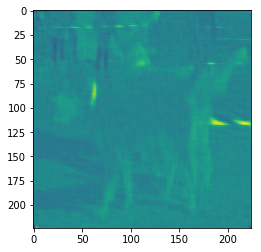

In [60]:
plt.imshow(a[:, :, 1])

In [61]:
i = np.append(XX_train[0,:,:,0:1], a, axis=2)
b = ycbcr2rgb(i)

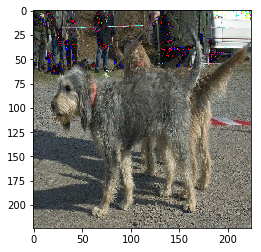

In [64]:
plt.imshow(b)